In [1]:
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
from collections import Counter
import shutil
import cv2
from PIL import Image
import glob
from tqdm import tqdm
from timeit import default_timer as timer
import random

In [3]:
def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

NUM_WORKERS = os.cpu_count()

image_size = (224, 224)
height, width = image_size
batch_size = 64

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
import os
import shutil

def merge_folders(folder1, folder2, destination_folder):

    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    for filename in os.listdir(folder1):
        source_path = os.path.join(folder1, filename)
        destination_path = os.path.join(destination_folder, filename)
        shutil.copy2(source_path, destination_path)

    for filename in os.listdir(folder2):
        source_path = os.path.join(folder2, filename)
        destination_path = os.path.join(destination_folder, filename)

        if os.path.exists(destination_path):
            base, extension = os.path.splitext(filename)
            new_filename = f"{base}_copy{extension}"
            destination_path = os.path.join(destination_folder, new_filename)

        shutil.copy2(source_path, destination_path)

folder1 = '/content/HAM10000_images_part_1'
folder2 = '/content/HAM10000_images_part_2'
destination_folder = '/content/train_image'

merge_folders(folder1, folder2, destination_folder)

print("Images merged successfully!")


Images merged successfully!


In [5]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

image_folder = '/content/train_image'
csv_file = '/content/HAM10000_metadata.csv'
metadata = pd.read_csv(csv_file)

train_dir = '/content/train'
test_dir = '/content/test'

if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

classes = metadata['dx'].unique()

for class_name in classes:
    class_train_dir = os.path.join(train_dir, class_name)
    class_test_dir = os.path.join(test_dir, class_name)
    if not os.path.exists(class_train_dir):
        os.makedirs(class_train_dir)
    if not os.path.exists(class_test_dir):
        os.makedirs(class_test_dir)

def find_image_file(image_id):
    image_file = image_id + '.jpg'
    if os.path.exists(os.path.join(image_folder, image_file)):
        return os.path.join(image_folder, image_file)
    else:
        return None

for class_name in classes:
    class_images = metadata[metadata['dx'] == class_name]['image_id'].tolist()
    train_images, test_images = train_test_split(class_images, test_size=0.2, random_state=42)

    for image_id in train_images:
        source_file = find_image_file(image_id)
        if source_file:
            shutil.copy(source_file, os.path.join(train_dir, class_name, os.path.basename(source_file)))

    for image_id in test_images:
        source_file = find_image_file(image_id)
        if source_file:
            shutil.copy(source_file, os.path.join(test_dir, class_name, os.path.basename(source_file)))

print("Dataset organized into train and test subfolders successfully!")

Dataset organized into train and test subfolders successfully!


In [6]:
train_dir = "/content/train"
test_dir = "/content/test"
train_dir, test_dir

('/content/train', '/content/test')

In [7]:
def balance_dataset(subset):
    # Access the dataset and targets from the Subset object
    dataset = subset.dataset
    subset_indices = subset.indices
    subset_targets = [dataset.targets[i] for i in subset_indices]

    # Count the instances per class
    class_counts = Counter(subset_targets)
    print(class_counts)

    balanced_indices = []
    for class_index, count in class_counts.items():
        # Determine the required number of images based on the given rules
        if count >= 1000:
            required_images = 3000
        elif 500 < count < 1000:
            required_images = 2500
        else:
            required_images = 2000

        # Collect indices of the current class
        class_indices = [subset_indices[i] for i, label in enumerate(subset_targets) if label == class_index]

        # Balance the class to the required number of images
        if count < required_images:
            additional_indices = np.random.choice(class_indices, required_images - count, replace=True)
            class_indices.extend(additional_indices)
        elif count > required_images:
            class_indices = np.random.choice(class_indices, required_images, replace=False).tolist()

        balanced_indices.extend(class_indices)

    return Subset(dataset, balanced_indices)


In [8]:
def create_dataloaders(
    train_dir: str,
    test_dir: str,
    train_transform: transforms.Compose,
    test_transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  full_train_data = datasets.ImageFolder(train_dir, transform=train_transform)
  test_data = datasets.ImageFolder(test_dir, transform=test_transform)

  train_indices, val_indices = train_test_split(list(range(len(full_train_data))), test_size=0.1, random_state=42)
  imbalanced_train_data = Subset(full_train_data, train_indices)
  val_data = Subset(full_train_data, val_indices)

  # Balance the training data
  train_data = balance_dataset(imbalanced_train_data)

  # Get class names
  class_names = full_train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  val_dataloader = DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, val_dataloader, test_dataloader, class_names


test_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
                          # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

train_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip with 50% probability
    transforms.RandomRotation(degrees=(-15, 15)),  # Rotate between -15 and 15 degrees
    # Add other transformations here (optional)
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                    test_dir=test_dir,
                                                                    train_transform=train_transforms,
                                                                    test_transform=test_transforms,
                                                                    batch_size=batch_size)

train_dataloader,  val_dataloader,test_dataloader, class_names

Counter({5: 4836, 4: 805, 2: 781, 1: 372, 0: 230, 6: 101, 3: 84})


(<torch.utils.data.dataloader.DataLoader at 0x7a0226972c10>,
 ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])

Class 5: 3000 images
Class 0: 2000 images
Class 4: 2500 images
Class 2: 2500 images
Class 1: 2000 images
Class 6: 2000 images
Class 3: 2000 images


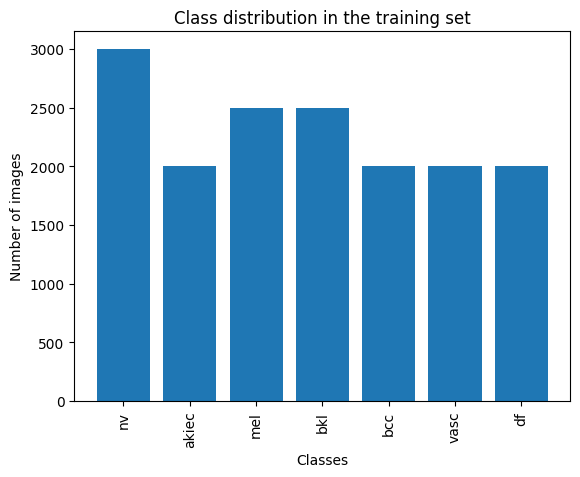

In [9]:
from collections import Counter

def count_classes(data_loader):
    # Access the dataset from the dataloader
    dataset = data_loader.dataset

    # If the dataset is a Subset, access the underlying dataset
    if isinstance(dataset, Subset):
        dataset = dataset.dataset
        indices = data_loader.dataset.indices
        targets = [dataset.targets[i] for i in indices]
    else:
        targets = dataset.targets

    # Count the occurrences of each class
    class_counts = Counter(targets)

    # Print the number of images in each class
    for class_idx, count in class_counts.items():
        print(f'Class {class_idx}: {count} images')

    return class_counts

# Example usage with train_dataloader
class_counts = count_classes(train_dataloader)

# Optionally, visualize the class distribution
classes = [train_dataloader.dataset.dataset.classes[i] for i in class_counts.keys()]
counts = list(class_counts.values())

plt.bar(classes, counts)
plt.xlabel('Classes')
plt.ylabel('Number of images')
plt.title('Class distribution in the training set')
plt.xticks(rotation=90)
plt.show()


In [10]:
!pip install torchinfo

In [11]:
from torchvision import models

model = models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1)

# Set all parameters to require gradients (for fine-tuning)
for param in model.parameters():
    param.requires_grad = True


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 143MB/s]


In [14]:
set_seeds()

output_shape = len(class_names)

#num_ftrs = model.fc.in_features
num_ftrs = model.classifier.in_features

# Recreate the classifier layer and seed it to the target device
#model.fc = torch.nn.Sequential(
model.classifier = torch.nn.Sequential(
    #torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=num_ftrs,
                    out_features=512, # same number of output units as our number of classes
                    bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=512,
                    out_features=128, # same number of output units as our number of classes
                    bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=128,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)



In [15]:
from torchinfo import summary
summary(model,
        input_size=(batch_size, 3, height, width), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [64, 3, 224, 224]    [64, 7]              --                   True
├─Sequential (features)                       [64, 3, 224, 224]    [64, 1920, 7, 7]     --                   True
│    └─Conv2d (conv0)                         [64, 3, 224, 224]    [64, 64, 112, 112]   9,408                True
│    └─BatchNorm2d (norm0)                    [64, 64, 112, 112]   [64, 64, 112, 112]   128                  True
│    └─ReLU (relu0)                           [64, 64, 112, 112]   [64, 64, 112, 112]   --                   --
│    └─MaxPool2d (pool0)                      [64, 64, 112, 112]   [64, 64, 56, 56]     --                   --
│    └─_DenseBlock (denseblock1)              [64, 64, 56, 56]     [64, 256, 56, 56]    --                   True
│    │    └─_DenseLayer (denselayer1)         [64, 64, 56, 56]     [64, 32, 56, 56]    

In [16]:
class CustomCallback:
    def __init__(self, initial_lr: float, factor: float = 0.04, c_check: bool = False):
        self.initial_lr = initial_lr
        self.factor = factor
        self.c_check = c_check
        self.best_loss = float('inf')
        self.best_weights = None
        self.lr = initial_lr

    def on_epoch_end(self, model: torch.nn.Module, val_loss: float, optimizer: torch.optim.Optimizer):
        if self.c_check:
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                self.best_weights = model.state_dict()
            else:
                print("Validation loss increased. Resetting model weights and reducing learning rate.")
                model.load_state_dict(self.best_weights)
                self.lr *= self.factor
                for param_group in optimizer.param_groups:
                    param_group['lr'] = self.lr
                print(f"New learning rate: {self.lr}")
        return self.lr

    def on_train_end(self, model: torch.nn.Module):
        if self.best_weights is not None:
            model.load_state_dict(self.best_weights)
        return model


In [17]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0


  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def val_step(model: torch.nn.Module,
            dataloader: torch.utils.data.DataLoader,
            loss_fn: torch.nn.Module,
            device: torch.device) -> Tuple[float, float]:

  # Put model in eval mode

  model.eval()

  # Setup test loss and test accuracy values
  val_loss, val_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          val_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(val_pred_logits, y)
          val_loss += loss.item()

          # Calculate and accumulate accuracy
          val_pred_labels = val_pred_logits.argmax(dim=1)
          val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  val_loss = val_loss / len(dataloader)
  val_acc = val_acc / len(dataloader)
  return val_loss, val_acc


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          callback: CustomCallback) -> Dict[str, List]:

  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "val_loss": [],
      "val_acc": []
  }
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)

      val_loss, val_acc = val_step(model=model,
          dataloader=val_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"val_loss: {val_loss:.4f} | "
          f"val_acc: {val_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["val_loss"].append(val_loss)
      results["val_acc"].append(val_acc)

      # Step the scheduler
      scheduler.step()

      #new_lr = callback.on_epoch_end(model, val_loss, optimizer)

  model = callback.on_train_end(model)

  # Return the filled results at the end of the epochs
  return results

In [18]:
initial_lr = 0.0001
weight_decay = 0.0001
factor = 0.04
c_check = False
callback = CustomCallback(initial_lr=initial_lr, factor=factor, c_check=c_check)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, weight_decay=weight_decay)

start_time = timer()
# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       val_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=9,
                       device=device,
                       callback=callback)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6032 | train_acc: 0.7917 | val_loss: 0.5616 | val_acc: 0.8189
Epoch: 2 | train_loss: 0.1645 | train_acc: 0.9426 | val_loss: 0.4755 | val_acc: 0.8442
Epoch: 3 | train_loss: 0.1031 | train_acc: 0.9649 | val_loss: 0.4674 | val_acc: 0.8612
Epoch: 4 | train_loss: 0.0359 | train_acc: 0.9891 | val_loss: 0.3997 | val_acc: 0.8861
Epoch: 5 | train_loss: 0.0251 | train_acc: 0.9920 | val_loss: 0.4487 | val_acc: 0.8837
Epoch: 6 | train_loss: 0.0163 | train_acc: 0.9951 | val_loss: 0.4889 | val_acc: 0.8730
Epoch: 7 | train_loss: 0.0104 | train_acc: 0.9971 | val_loss: 0.4119 | val_acc: 0.8968
Epoch: 8 | train_loss: 0.0049 | train_acc: 0.9990 | val_loss: 0.4357 | val_acc: 0.8899
Epoch: 9 | train_loss: 0.0064 | train_acc: 0.9979 | val_loss: 0.3857 | val_acc: 0.9077
[INFO] Total training time: 2535.417 seconds


In [ ]:
torch.save(model.state_dict(), 'mobilenetv2_model.pth')

Test Loss: 0.4547
Overall Accuracy: 0.9012
Macro Accuracy: 0.8137
Weighted Accuracy: 0.9012
AUC: 0.8935
Sensitivity (Recall): 0.8137
Specificity (Precision): 0.8783

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.65      0.75        66
           1       0.80      0.88      0.84       103
           2       0.86      0.80      0.83       220
           3       1.00      0.78      0.88        23
           4       0.75      0.75      0.75       223
           5       0.94      0.96      0.95      1341
           6       0.93      0.86      0.89        29

    accuracy                           0.90      2005
   macro avg       0.88      0.81      0.84      2005
weighted avg       0.90      0.90      0.90      2005



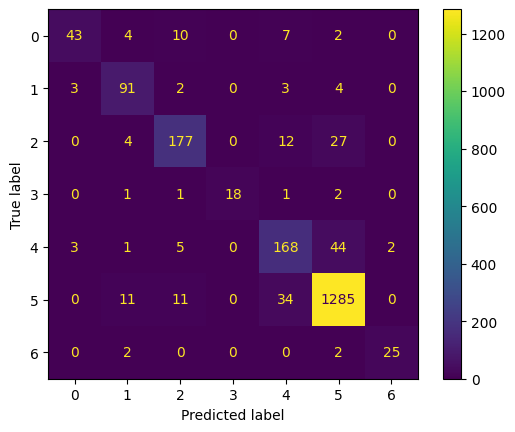

In [19]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    roc_auc_score,
    recall_score,
    precision_score
)
from sklearn.preprocessing import label_binarize
import numpy as np

model.eval()

# Initialize test loss and accuracy metrics
test_loss, test_acc = 0, 0
all_preds = []
all_labels = []

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(test_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model(X)

        # 2. Calculate and accumulate loss
        loss = loss_fn(test_pred_logits, y)
        test_loss += loss.item()

        # Calculate and accumulate accuracy
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

        # Store predictions and labels for later metric calculations
        all_preds.extend(test_pred_labels.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Average test loss and accuracy
test_loss = test_loss / len(test_dataloader)
test_acc = test_acc / len(test_dataloader)

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_preds)

# Calculate macro and weighted accuracy
macro_accuracy = recall_score(all_labels, all_preds, average="macro")
weighted_accuracy = recall_score(all_labels, all_preds, average="weighted")

# Calculate AUC score (multi-class handling with one-vs-rest if needed)
num_classes = len(np.unique(all_labels))
if num_classes > 2:
    all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))
    all_preds_bin = label_binarize(all_preds, classes=np.arange(num_classes))
    auc = roc_auc_score(all_labels_bin, all_preds_bin, average="macro", multi_class="ovr")
else:
    auc = roc_auc_score(all_labels, all_preds)

# Calculate sensitivity (recall) and specificity (precision)
sensitivity = recall_score(all_labels, all_preds, average="macro")
specificity = precision_score(all_labels, all_preds, average="macro")

# Confusion matrix and classification report
conf_matrix = confusion_matrix(all_labels, all_preds)
conf_matrix_display = ConfusionMatrixDisplay(conf_matrix)
classification_rep = classification_report(all_labels, all_preds)

# Display test loss, accuracy, and other metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Macro Accuracy: {macro_accuracy:.4f}")
print(f"Weighted Accuracy: {weighted_accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity (Precision): {specificity:.4f}")
print("\nClassification Report:\n", classification_rep)

# Display confusion matrix
conf_matrix_display.plot()


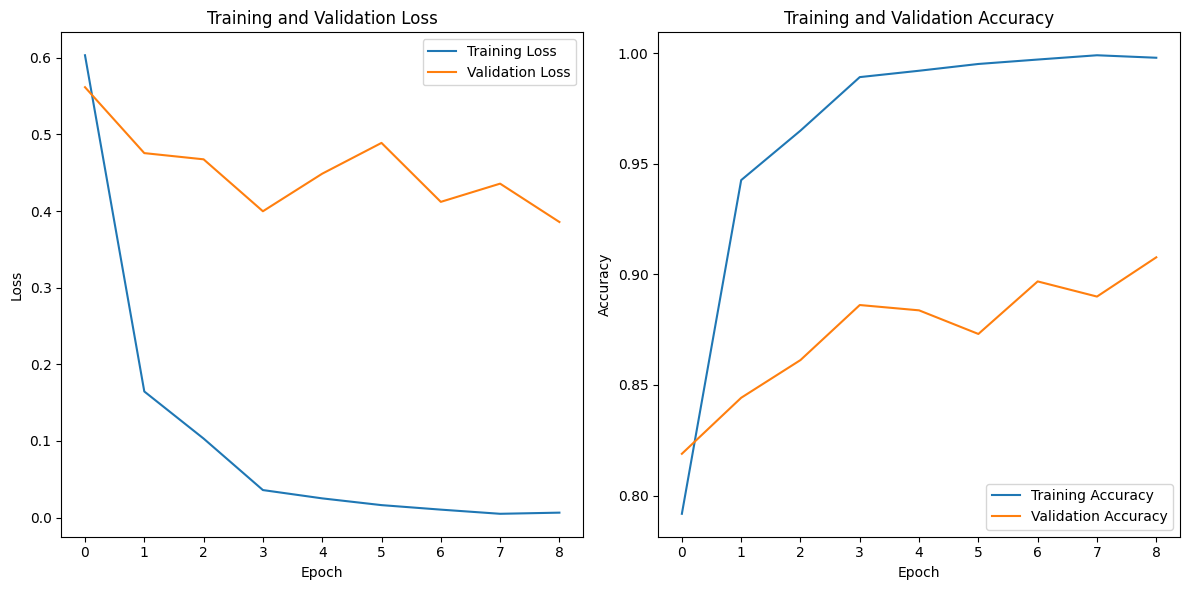

In [20]:
def plot_learning_curves(results):
    # Extracting loss and accuracy values from results
    loss = results['train_loss']
    val_loss = results['val_loss']
    accuracy = results['train_acc']
    val_accuracy = results['val_acc']

    # Plotting loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(results)


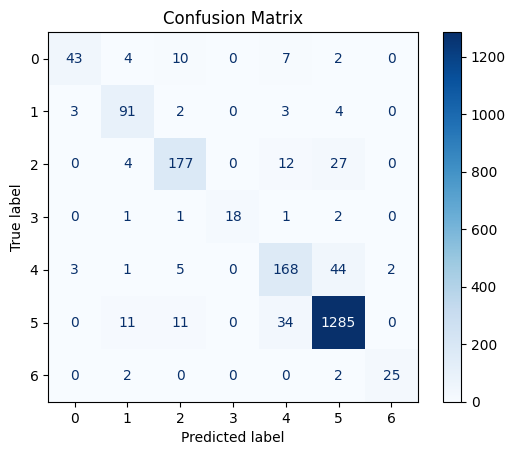

In [21]:
# Compute and plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

In [ ]:
#from google.colab import runtime
#runtime.unassign()